In [1]:
using DifferentialEquations
using Plots
using DiffEqSensitivity
using ForwardDiff
using GlobalSensitivity
using Statistics
using Printf

In [2]:
function model(du,u,p,t)
    
    # PARAMATERS
    # Load paramaters
    organic_carbon_input = p[1]
    inorganic_carbon_input = p[2]
    natural_death_fraction = p[3]
    ks = p[4]
    organic_carbon_content_per_cell = p[5]
    inorganic_carbon_content_per_cell = p[6]
    mu_max = p[7]
    base_maintenance_per_cell = p[8]
    m_prime = p[9]
    maximum_growth_yield = p[10]
    inorganic_carbon_fixing_factor = p[11]
    carrying_capacity = p[12]
    

    # Load state conditions
    organic_carbon_content = u[1]
    inorganic_carbon_content = u[2]
    cell_count = u[3]


    ## CELL COUNT
    # Growth
    growth = mu_max * (organic_carbon_content / (ks + organic_carbon_content)) * cell_count * (
            1 - cell_count / carrying_capacity)

    # Specific growth rate
    next_cell_count = cell_count + growth
    specific_growth_rate = 0
    if next_cell_count > 0 and cell_count > 0:
        specific_growth_rate = max((np.log(next_cell_count) - np.log(cell_count)), 0)

    # Organic carbon requirement
    required_organic_carbon_per_cell = base_maintenance_per_cell  + m_prime * (1 - specific_growth_rate/mu_max)
    required_organic_carbon = required_organic_carbon_per_cell * cell_count

    # Starvation
    organic_carbon_missing = max(required_organic_carbon - organic_carbon_content, 0)
    
    starvation_deaths = organic_carbon_missing == 0 ? 0 : organic_carbon_missing / required_organic_carbon_per_cell

    # Natural Death
    natural_deaths = natural_death_fraction * cell_count - natural_death_fraction * starvation_deaths

    # Deaths
    deaths = natural_deaths + starvation_deaths

    # Net cell count change
    du[3] = growth - deaths

    ## CARBON
    carbon_consumption = required_organic_carbon_per_cell * (cell_count - deaths)
    fixed_carbon = inorganic_carbon_fixing_factor * inorganic_carbon_content

    # Inorganic carbon
    du[2] = inorganic_carbon_input + inorganic_carbon_content_per_cell * (
            deaths - growth) + carbon_consumption - fixed_carbon

    # Organic carbon
    du[1] = organic_carbon_input + organic_carbon_content_per_cell * (
            deaths - growth) - carbon_consumption + fixed_carbon
    
end

model (generic function with 1 method)

In [5]:
p = [0, 0.0, 0.001, 882000000.0, 140.0, 0.0, 0.06, 2.1739130434782608, 0.0, 1.0406549188289163, 0.0, 1000000000.0]
duration = 11000 * 365.25 # In days

u0 = [1286820000000.0; 0.0; 100000.0]
tspan = (0.0, duration)
prob = ODEProblem(model,u0,tspan,p)
sol = solve(prob, reltol=1e-9, abstol=1e-9)

S = plot(sol, vars=(1), yaxis="Organic C")
I = plot(sol, vars=(2), yaxis="Inorganic C")
N = plot(sol, vars=(3), yaxis="Cells")


plot(plot(N),plot(I, S, layout=(1,2)), layout=(2,1))

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = (::DefaultLinSolve)(x::Vector{Float64}, A::Matrix{Float64}, b::Vector{Float64}, update_matrix::Bool; reltol::Nothing, kwargs::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}) at linear_nonlinear.jl:91
└ @ DiffEqBase /Users/GeorgesKanaan/.julia/packages/DiffEqBase/niZxn/src/linear_nonlinear.jl:91


Total order indices:
organic_carbon_input: Fixed value
inorganic_carbon_input: Fixed value
natural_death_fraction: Fixed value
ks: 0.000
organic_carbon_content_per_cell: 0.137
inorganic_carbon_content_per_cell: 0.124
mu_max: 0.161
base_maintenance_per_cell: 0.276
m_prime: 0.000
maximum_growth_yield: Fixed value
inorganic_carbon_fixing_factor: 0.404
carrying_capacity: Fixed value

First order indices:
organic_carbon_input: Fixed value
inorganic_carbon_input: Fixed value
natural_death_fraction: Fixed value
ks: -0.000
organic_carbon_content_per_cell: 0.092
inorganic_carbon_content_per_cell: 0.113
mu_max: 0.091
base_maintenance_per_cell: 0.241
m_prime: 0.000
maximum_growth_yield: Fixed value
inorganic_carbon_fixing_factor: 0.326
carrying_capacity: Fixed value


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://diffeq.sciml.ai/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/GeorgesKanaan/.julia/packages/SciMLBase/UEAKN/src/integrator_interface.jl:352
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://diffeq.sciml.ai/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/GeorgesKanaan/.julia/packages/SciMLBase/UEAKN/src/integrator_interface.jl:352


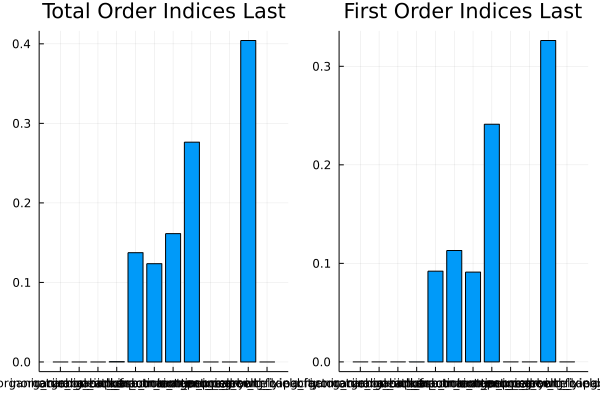

In [9]:
p_names = ["organic_carbon_input", "inorganic_carbon_input", "natural_death_fraction", "ks", "organic_carbon_content_per_cell", "inorganic_carbon_content_per_cell", "mu_max", "base_maintenance_per_cell", "m_prime", "maximum_growth_yield", "inorganic_carbon_fixing_factor", "carrying_capacity"]
p_range = [[0, 0], [0, 0], [0.001, 0.001], [0.001, 10000000000], [0, 500], [0, 500], [0.000000001, 0.1], [0, 400], [0, 10000000], [0, 0], [0, 1], [1000000000, 1000000000]]


f1 = function (p)
  prob1 = remake(prob;p=p)
  sol = solve(prob1, Rosenbrock23(); saveat=collect(range(0, stop=duration, length=200)), maxiters=Int(1e6))
  [last(sol[1,:])]
end

sobol_result = GlobalSensitivity.gsa(f1, Sobol(), p_range, N=1000)

p1 = bar(p_names,sobol_result.ST[1,:],title="Total Order Indices Last",legend=false)
p2 = bar(p_names,sobol_result.S1[1,:],title="First Order Indices Last",legend=false)

println("Total order indices:")
for (index, value) in enumerate(sobol_result.ST[1,:])
    if p_range[index][1] == p_range[index][2]
        println(p_names[index] * ": Fixed value")
    else
        @printf("%s: %.3f\n", p_names[index], value)
    end
end

println("")
println("First order indices:")

for (index, value) in enumerate(sobol_result.S1[1,:])
    if p_range[index][1] == p_range[index][2]
        println(p_names[index] * ": Fixed value")
    else
        @printf("%s: %.3f\n", p_names[index], value)
    end
end

plot(p1, p2)